In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from sklearn.utils import shuffle
import glob
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers

In [2]:
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 1000)


Read numpy files

In [3]:
# Get the paths where all the files are stored
current_path = os.getcwd()
data_path = current_path + '/Data'

In [4]:
# Load data
xtrain = np.load(data_path+'/xtrain0.npy')
ytrain = np.load(data_path+'/ytrain0.npy')
xval = np.load(data_path+'/xval0.npy')
yval = np.load(data_path+'/yval0.npy')

In [5]:
# Convert labels to categorical columns
ylabel_tr = tf.keras.utils.to_categorical(ytrain, 10)
ylabel_val = tf.keras.utils.to_categorical(yval, 10)
# Expand dims for the training and validation data
xtrain = np.expand_dims(xtrain,axis=-1)
xval = np.expand_dims(xval,axis=-1)

In [8]:
np.shape(xtrain), np.shape(ylabel_tr), np.shape(xval), np.shape(ylabel_val)

((38000, 28, 28, 1), (38000, 10), (4000, 28, 28, 1), (4000, 10))

In [7]:
# Load the whole dataset
xtrain_wh = np.load(data_path+'/xtrain.npy')
ytrain_wh = np.load(data_path+'/ytrain.npy')
# Expand dims for the training and validation data
xtrain_wh = np.expand_dims(xtrain_wh,axis=-1)
# Convert labels to categorical columns
ytrain_wh = tf.keras.utils.to_categorical(ytrain_wh, 10)
print('shape of whole datasets',np.shape(xtrain_wh), np.shape(ytrain_wh))

shape of whole datasets (42000, 28, 28, 1) (42000, 10)


In [34]:
# Load the whole test dataset
xtest = np.load(data_path+'/xtest.npy')
# Expand dims for the test data
xtest = np.expand_dims(xtest,axis=-1)
print('shape of whole datasets',np.shape(xtest))

shape of whole datasets (28000, 28, 28, 1)


Create Model for training

In [9]:
def build_model(input_shape, kernel_list, learn_rate, output_shape):
    """
    Build a convolutional neural network for image classification
    
    Input Args:
    input shape: Shape of the input image provided. The input shape should be 28x28x1
    kernel_list: List of kernel level information. Its a list of list containing per 
                    level number of kernels and the kernel shape of the model.
    learn_rate: Learning rate of the optimizer
    output_shape: Shape of the final layer of the model. 10 in our case
    
    Output Args:
    model: Tensorflow model which is compiled
    """
    def conv_block(num_kernels, kernel_shape, stride_shape,input_layer, layer_num):
        """
        Create a convolution block which is a convolution layer followed by activation
        
        Input Args:
        num_kernels: Number of kernels in the convolution layer
        kernel_shape: Shape of the kernels in the convolution layer
        stride_shape: Shape of the strides in the convolution layer
        input_layer: Input layer connected to the block
        layer_num: Layer number in the model
        
        Output Args:
        out: Output Layer of the convolution block
        """
        conv = layers.Conv2D(num_kernels, 
                                 kernel_shape, 
                                 padding='valid', 
                                 activation='relu',
                                 strides=stride_shape,
                                 name = 'conv'+str(layer_num))(input_layer)
        bn = layers.BatchNormalization(name = 'batchnorm'+str(layer_num))(conv)
        out = layers.MaxPool2D(pool_size=(3, 3), 
                             strides=(1, 1), 
                             name='maxpool'+str(layer_num),
                             padding='same')(bn)
        return out
    
    # Create convolution block
    input_layer = layers.Input(shape=input_shape, name='input_layer')
    # Connect input image to the first convolution block
    x = conv_block(kernel_list[0][0], kernel_list[0][1], kernel_list[0][2],input_layer, 1)
    # Connect rest of the block to each other
    for i in range(1, len(kernel_list)):
        kernel = kernel_list[i]
        x = conv_block(kernel[0], kernel[1], kernel[2],x, i+1)
    
    # Connect Flatten layers and add output layer
    flatten = layers.Flatten(name='flatten')(x)
    dense1 = layers.Dense(50, name = 'dense1')(flatten)
    out_layer = layers.Dense(output_shape, activation='softmax', name = 'dense2')(dense1)
    
    # Define input and outputs of the model
    model = models.Model(input_layer, out_layer)
    
    # Compile the model
    adam = optimizers.Adam(lr=learn_rate)
    model.compile(optimizer=adam,loss='categorical_crossentropy',metrics=['accuracy'])
    print(model.summary())
    return model

In [61]:
# Parameters and hyperparameters of the model
output_shape = len(np.unique(ytrain))
input_shape = np.shape(xtrain[0,:,:,:])
kernel_list = [[32, (3,3), (1,1)],
              [32, (3,3), (2,2)],
                [32, (3,3), (1,1)],
              [32, (3,3), (1,1)],
              [64, (3,3), (1,1)],
               [64, (3,3), (1,1)]]
learn_rate = 5*10**-4
num_iterr = 50
batch_size = 32

In [62]:
def train_model(xtrain, ylabel_tr, xval, ylabel_val, input_shape, kernel_list, learn_rate, output_shape, num_iterr, batch_size=32):
    """
    Function to train model
    
    Input Args:
    xtrain: Input images in numpy format
    ylabel_tr: Input image labels
    xval: Validation images as numpy format
    ylabel_val: Validation image labels
    input_shape: Shape of the input image provided. The input shape should be 28x28x1
    kernel_list: List of kernel level information. Its a list of list containing per 
                    level number of kernels and the kernel shape of the model.
    learn_rate: Learning rate of the optimizer
    output_shape: Shape of the final layer of the model. 10 in our case
    num_iterr: Number of epochs for training
    batch_size: Number of batches of images per epoch
    
    Output Args:
    models: Weights of the model at each step
    loss_list: List of training loss
    accuracy_list: List of training accuracy 
    val_loss_list: List of validation loss
    val_acc_list: List of validation accuracy
    """
    val_loss_list = []
    val_acc_list = []
    loss_list = []
    accuracy_list = []
    model_wt_dict = {}
    # Initialize the model
    model = build_model(input_shape, 
                        kernel_list, 
                        learn_rate, 
                        output_shape)
    # Train the model
    for i in range(num_iterr):
        print('Epoch number:{0}/{1}'.format(i+1, num_iterr))
        history = model.fit(xtrain, 
                            ylabel_tr, 
                            epochs=1, 
                            validation_data=(xval, ylabel_val),
                            batch_size = batch_size)
        # get the training and validation loss and accuracy
        train_loss = history.history['loss']
        train_acc = history.history['accuracy']
        val_loss = history.history['val_loss']
        val_acc = history.history['val_accuracy']
        # Store all the metrics for training and validation samples
        loss_list.append(train_loss)
        accuracy_list.append(train_acc)
        # Store the model weights, and history
        model_weights = model.get_weights() 
        model_wt_dict[i] = model_weights
        val_loss_list.append(val_loss)
        val_acc_list.append(val_acc)
        loss_list.append(train_loss)
        accuracy_list.append(train_acc)
    return model_wt_dict, loss_list, accuracy_list, val_loss_list, val_acc_list

Perform model training

In [63]:
model_wt_dict, loss_list, accuracy_list, val_loss_list, val_acc_list = train_model(xtrain, 
                                                                            ylabel_tr,
                                                                            xval, 
                                                                            ylabel_val, 
                                                                            input_shape, 
                                                                            kernel_list, 
                                                                            learn_rate, 
                                                                            output_shape,
                                                                            num_iterr,
                                                                            batch_size)

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 26, 26, 32)        320       
_________________________________________________________________
batchnorm1 (BatchNormalizati (None, 26, 26, 32)        128       
_________________________________________________________________
maxpool1 (MaxPooling2D)      (None, 26, 26, 32)        0         
_________________________________________________________________
conv2 (Conv2D)               (None, 12, 12, 32)        9248      
_________________________________________________________________
batchnorm2 (BatchNormalizati (None, 12, 12, 32)        128       
_________________________________________________________________
maxpool2 (MaxPooling2D)      (None, 12, 12, 32)        0   

KeyboardInterrupt: 

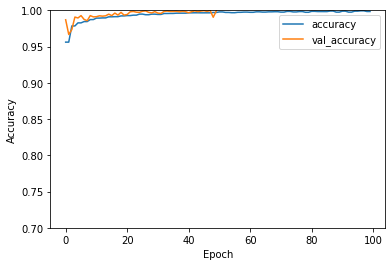

In [26]:
plt.plot(accuracy_list, label='accuracy')
plt.plot(val_acc_list, label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.7, 1])
plt.legend(loc='best')
plt.show()

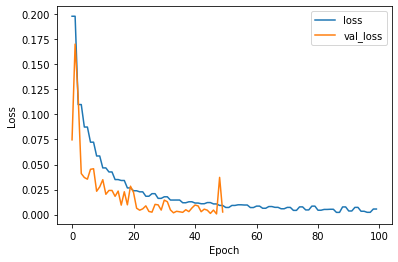

In [27]:
plt.plot(loss_list, label='loss')
plt.plot(val_loss_list, label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='best')
plt.show()

In [28]:
# Find model with the least validation loss
index = np.argmin(val_loss_list)
# Use that index to retrieve model weights
model_wt = model_wt_dict[index]
print('Best model is at {0}th epoch'.format(index))

Best model is at 47th epoch


In [29]:
# Load the model with weights
model = build_model(input_shape, 
                        kernel_list, 
                        learn_rate, 
                        output_shape)
model.set_weights(model_wt)

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 26, 26, 32)        320       
_________________________________________________________________
batchnorm1 (BatchNormalizati (None, 26, 26, 32)        128       
_________________________________________________________________
maxpool1 (MaxPooling2D)      (None, 26, 26, 32)        0         
_________________________________________________________________
conv2 (Conv2D)               (None, 24, 24, 32)        9248      
_________________________________________________________________
batchnorm2 (BatchNormalizati (None, 24, 24, 32)        128       
_________________________________________________________________
maxpool2 (MaxPooling2D)      (None, 24, 24, 32)        0   

Evaluate the model

In [30]:
# Test accuray on the validation dataset
test_loss, test_accuracy = model.evaluate(xval,  ylabel_val, verbose=2)

print('\nTest accuracy = {0:.2f}%'.format(test_accuracy*100.0))

4000/4000 - 2s - loss: 7.4007e-04 - accuracy: 0.9998

Test accuracy = 99.98%


In [31]:
# Test accuracy on the entire dataset
train_wh_loss, train_wh_accuracy = model.evaluate(xtrain_wh,  ytrain_wh, verbose=2)

print('\nTrain accuracy on whole dataset = {0:.2f}%'.format(train_wh_accuracy*100.0))

42000/42000 - 8s - loss: 0.0063 - accuracy: 0.9989

Train accuracy on whole dataset = 99.89%


Save the model

In [32]:
# Check if save path exists, if not then create one
save_path = current_path + '/model' 
if not os.path.isdir(save_path):
    os.makedirs(save_path)

In [59]:
def create_submission(model, xtest, current_path):
    """
    Create keggale submission csv. This also performs prediction on xtest
    
    Input Args:
    model: Trained model
    xtest: Numpy image of the test dataset
    current_path: Path where submission file has to be created.
                    It takes the previously stored sample submission file which you get 
                    from kaggle dataset
    """
    # Predict test set labels
    ypred = model.predict(xtest)
    # Get labels for each row with maximum column value
    ytest_label = np.argmax(ypred, axis=1)
    # read the sample submission file 
    samp_submission_df = pd.read_csv(current_path+'/sample_submission.csv')
    # add the the new ytest label 
    samp_submission_df.loc[:,'Label'] = ytest_label
    # Save the file as submission 
    samp_submission_df.to_csv(current_path + '/submission.csv', index=False)

In [60]:
# Save model if the accuracy on whole dataset is greater than 99.82 and also create test submission
if round(train_wh_accuracy*100.0,3) > 99.82:
    filename = save_path + '/model' + str(round(train_wh_accuracy*100.0,3))
    model_json = model.to_json()
    with open(filename + '.json', "w") as json_file:
        json_file.write(model_json)

    # Save weights of the model
    model.save_weights(filename+'.h5')
    # Create submission
    create_submission(model, xtest, current_path)
    